In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from uncertainties import ufloat
from uncertainties.umath import sqrt
import scipy.constants as c

1024


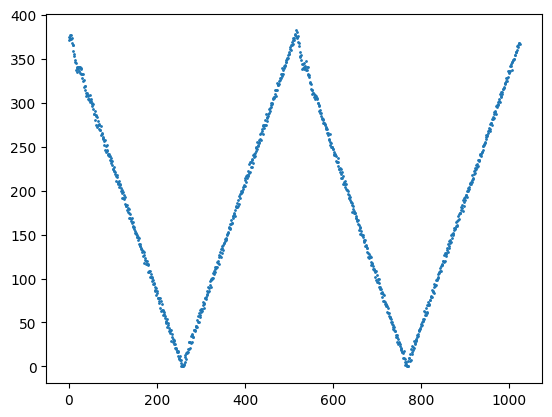

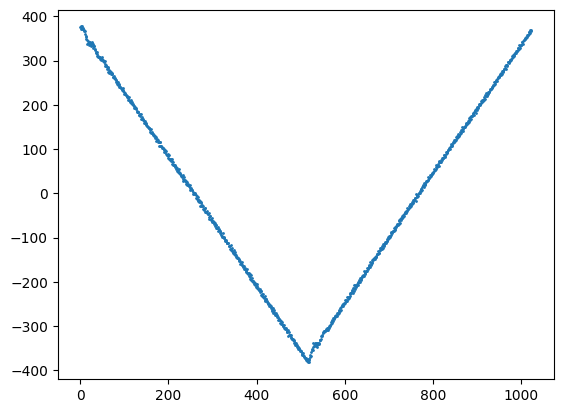

In [2]:
spectrum = np.loadtxt('data/VelocityCalibration_2025-12-15_10-03-29_10_seconds.txt', delimiter = ' ', skiprows = 0)
print(spectrum.shape[0])
plt.scatter(np.arange(spectrum.shape[0]),spectrum,s=1)
#new_spectrum = spectrum[:512] + spectrum[512:]
#plt.scatter(np.arange(spectrum.shape[0]/2),new_spectrum)

plt.show()

new2_spectrum = spectrum
new2_spectrum[int(1024/4):int(1024/4*3)] *= -1

plt.scatter(np.arange(new2_spectrum.shape[0]),new2_spectrum,s=1)




[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 512
    # variables        = 2
    chi-square         = 5388.82864
    reduced chi-square = 10.5663307
    Akaike info crit   = 1209.12445
    Bayesian info crit = 1217.60110
    R-squared          = 0.99977380
[[Variables]]
    slope:     -4.8565e-05 +/- 3.2347e-08 (0.07%) (init = -5e-05)
    intercept:  0.01245760 +/- 9.5478e-06 (0.08%) (init = 0.015)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.8656
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 512
    # variables        = 2
    chi-square         = 5153.93486
    reduced chi-square = 10.1057546
    Akaike info crit   = 1186.30586
    Bayesian info crit = 1194.78251
    R-squared          = 0.99978378
[[Variables]]
    slope:      4.8578e-05 +/- 3.1634e-08 (0.07%) (init = 500000)
    intercept: -0.03733839 +/- 2.4725e-05 (0.07%) 

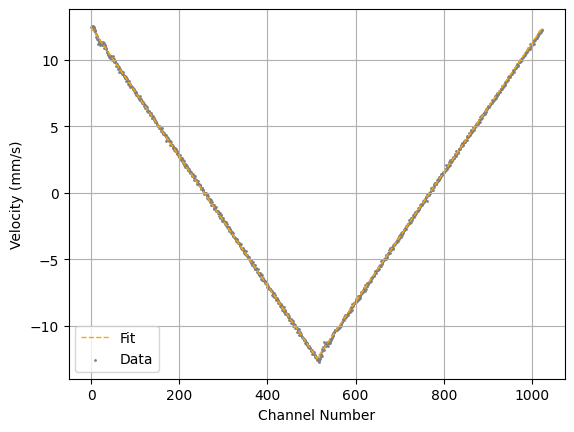

In [3]:
from lmfit.models import LinearModel
from lmfit import Minimizer, report_fit,create_params


model = LinearModel()

spectrum_left = new2_spectrum[:512]
spectrum_right = new2_spectrum[512:]
params_left = create_params(slope = -5e-5, intercept = 0.015)
params_right = create_params(slope=5e5,intercept=-0.03)
#whats the uncertainty on this? idk I think he said about one
y_uncertainty = np.ones(len(spectrum_left))
lambda_0 = 650e-9  # meters
scan_time = 10  # seconds

velocity_left = lambda_0 / (2 * scan_time) *spectrum_left *1024
velocity_right = lambda_0 / (2 * scan_time) *spectrum_right *1024
velocity_uncertainty_left = lambda_0 / (2 * scan_time) * y_uncertainty *1024
velocity_uncertainty_right = lambda_0 / (2 * scan_time) * y_uncertainty *1024






x_data_left = np.arange(spectrum_left.shape[0])
result1 = model.fit(velocity_left, params_left, x=x_data_left, weights=1/velocity_uncertainty_left)
bestfit1 = result1.best_fit
dely1 = result1.eval_uncertainty(sigma=1)



x_data_right = np.arange(spectrum_right.shape[0]) + spectrum_left.shape[0] 
result2 = model.fit(velocity_right,params_right, x= x_data_right, weights = 1/velocity_uncertainty_right)
bestfit2 = result2.best_fit
dely2 = result2.eval_uncertainty(sigma=1)


print(report_fit(result1))
print(report_fit(result2))


results = np.zeros(1024)
results[:512]= bestfit1
results[512:]= bestfit2

result_unc = np.zeros(1024)
result_unc[:512]=dely1
result_unc[512:]=dely2
x_data = np.arange(1024)
plt.plot(x_data,results*10**3,color="orange",label='Fit',linestyle='--',linewidth=1)
plt.ylabel('Velocity (mm/s)')
plt.xlabel('Channel Number')
plt.fill_between(x_data, (results - result_unc)*10**3, (results + result_unc)*10**3, color='gray', alpha=0.5)
plt.scatter(x_data, new2_spectrum * lambda_0 / (2 * scan_time) * 1024 *10**3, s=1, color='gray', label='Data')
plt.legend()
plt.grid()
plt.show()
#print(results)

data_to_save = np.column_stack((x_data, results, result_unc))
np.savetxt('fit_results.csv', data_to_save, delimiter=',', 
           header='x,y_fit,uncertainty', comments='')



In [4]:
#READ DATA

filename = 'data/StainlessSteel.txt'

with open(filename, 'r') as f:
    lines = f.readlines()

# Determine dimensions from file structure
n_rows = len(lines)
n_cols = len(lines[0].strip().split())

# Read as 2D numpy array
data_2d = np.loadtxt(filename).reshape(n_rows, n_cols)

print(data_2d)

[[19. 21. 14. ... 19. 18. 19.]
 [15. 22. 24. ... 24. 24. 22.]
 [16. 20. 24. ... 36. 19. 25.]
 ...
 [ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


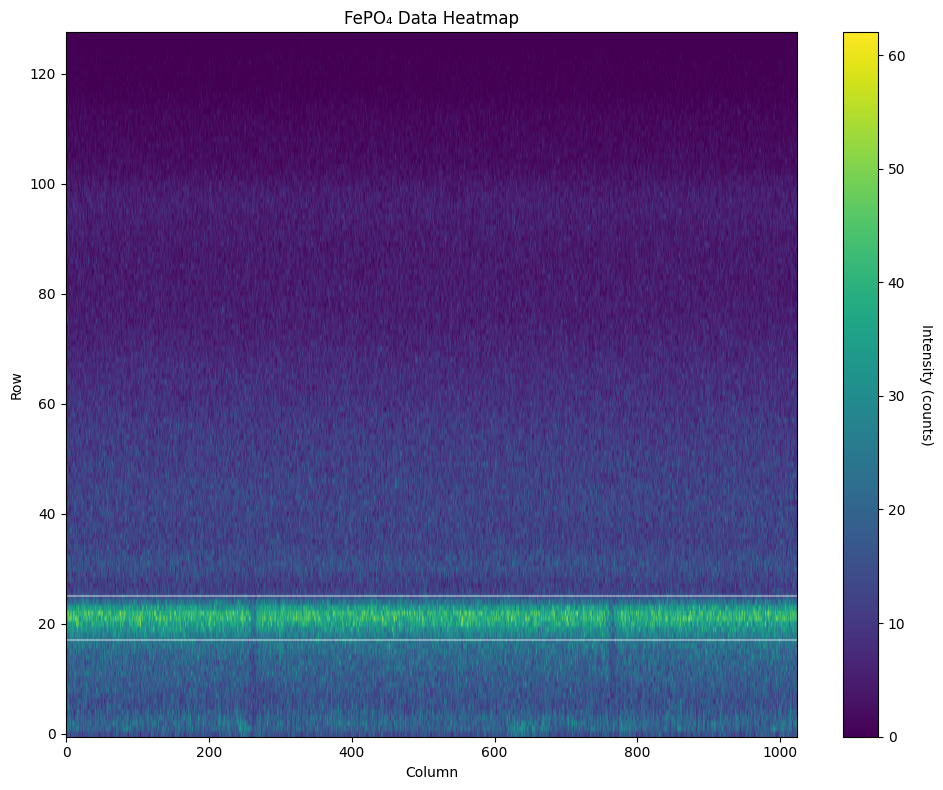

In [22]:
row_low, row_high = 17, 25   # rows you want to use


# Fit 1:
fit1_low=results[205]
fit1_high=results[315]

peak1_low=results[261]


# Fit 2:
fit2_low=results[715]
fit2_high=results[815]

peak2_low=results[763]




# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(data_2d, cmap='viridis', aspect='auto', origin='lower')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Intensity (counts)', rotation=270, labelpad=20)

# Labels
ax.set_xlabel('Column')
ax.set_ylabel('Row')
ax.set_title('FePO₄ Data Heatmap')

plt.tight_layout()

#peak
plt.axvline(peak1_low, color = 'red', linewidth = 0.4)
plt.axvline(peak2_low, color = 'red', linewidth = 0.4)

#fit
plt.axvline(fit1_low, color = 'green', linewidth = 0.4)
plt.axvline(fit1_high, color = 'green', linewidth = 0.4)
plt.axvline(fit2_low, color = 'green', linewidth = 0.4)
plt.axvline(fit2_high, color = 'green', linewidth = 0.4)

plt.axhline(row_low,color= "white",alpha=0.4)
plt.axhline(row_high,color= "white",alpha=0.4)
plt.show()


In [23]:
# Restrict to useful band in Y
band = data_2d[row_low:row_high+1, :]  # shape: (rows, cols)

# Sum (or average) over rows to make a 1D spectrum vs column
spectrum = band.sum(axis=0)   # or band.mean(axis=0)

channels = results[np.arange(band.shape[1])]    # x-axis = channel index

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(channels[fit1_low:fit1_high+1]*1e3, spectrum[fit1_low:fit1_high+1],'x')
plt.plot(channels[fit2_low:fit2_high+1]*1e3, spectrum[fit2_low:fit2_high+1],'x')
plt.xlabel('velocity [mm/s]')
plt.ylabel('Counts (or absorption)')
plt.title('Mössbauer spectrum from 2D map')
plt.tight_layout()
plt.axvline(results[peak1_low]*1e3, color = 'red', linewidth = 0.4)

plt.show()

TypeError: slice indices must be integers or None or have an __index__ method

<Figure size 800x400 with 0 Axes>

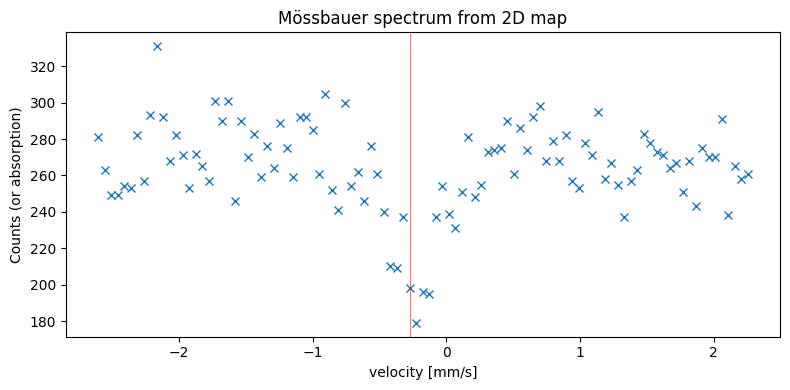

In [13]:
plt.figure(figsize=(8, 4))
plt.plot(channels[fit2_low:fit2_high+1]*1e3, spectrum[fit2_low:fit2_high+1],'x')
plt.xlabel('velocity [mm/s]')
plt.ylabel('Counts (or absorption)')
plt.title('Mössbauer spectrum from 2D map')
plt.tight_layout()
plt.axvline(results[peak2_low]*1e3, color = 'red', linewidth = 0.4)

plt.show()

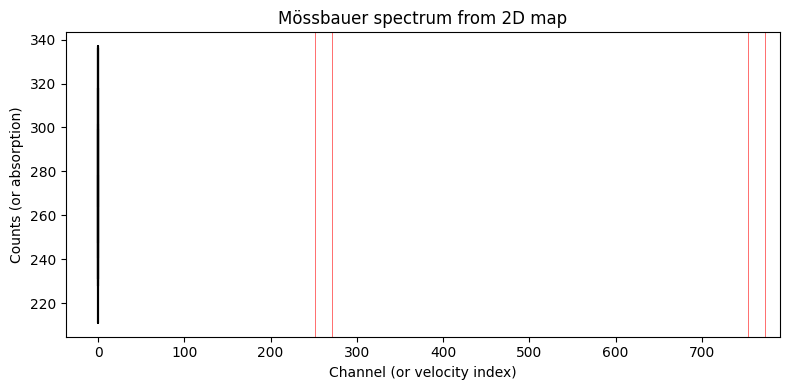

In [15]:
k1_low=peak1_low-10
k1_high=peak1_low+10

k2_low=peak2_low-10
k2_high=peak2_low+10

plt.figure(figsize=(8, 4))
plt.plot(channels[0:k1_low], spectrum[0:k1_low],'-k')
plt.plot(channels[k1_high:k2_low], spectrum[k1_high:k2_low],'-k')
plt.plot(channels[k2_high:], spectrum[k2_high:],'-k')


plt.xlabel('Channel (or velocity index)')
plt.ylabel('Counts (or absorption)')
plt.title('Mössbauer spectrum from 2D map')
plt.tight_layout()

plt.axvline(k1_low, color = 'red', linewidth = 0.4)
plt.axvline(k1_high, color = 'red', linewidth = 0.4)
plt.axvline(k2_low, color = 'red', linewidth = 0.4)
plt.axvline(k2_high, color = 'red', linewidth = 0.4)

plt.show()

Background mean: 272.166015625
Background sigma: 18.607584652289802


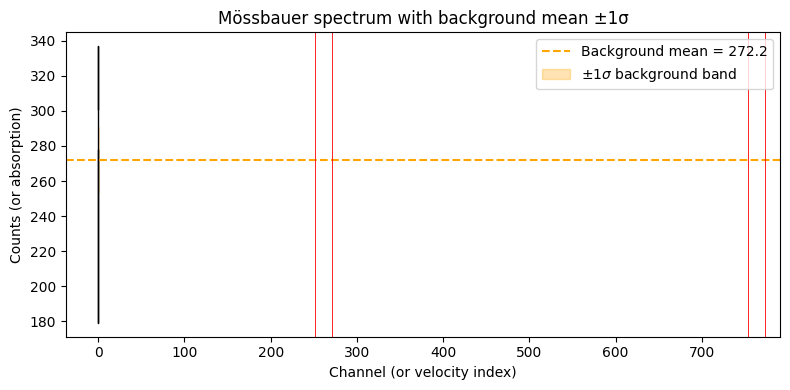

In [16]:
# Boolean mask for background channels (outside both peak regions)
bg_mask = (
    (channels < k1_low) |
    ((channels > k1_high) & (channels < k2_low)) |
    (channels > k2_high)
)

# Extract background y-values
bg_values = spectrum[bg_mask]

bg_mean = bg_values.mean()
bg_sigma = bg_values.std(ddof=1)   # sample sigma [web:35]

print("Background mean:", bg_mean)
print("Background sigma:", bg_sigma)

# Plot spectrum with background band
plt.figure(figsize=(8, 4))

# Your three background segments + peaks (optional: show full spectrum)
plt.plot(channels, spectrum, '-k', lw=1)

# Horizontal mean line
plt.axhline(bg_mean, color='orange', linestyle='--', label=f'Background mean = {bg_mean:.1f}')

# Shaded ±1σ band over the *background* x-range
x_bg = channels[bg_mask]
plt.fill_between(
    x_bg,
    bg_mean - bg_sigma,
    bg_mean + bg_sigma,
    color='orange',
    alpha=0.3,
    label=r'$\pm 1\sigma$ background band'
)  # [web:23][web:28]

# Peak markers
plt.axvline(k1_low,  color='red', linewidth=0.6)
plt.axvline(k1_high, color='red', linewidth=0.6)
plt.axvline(k2_low,  color='red', linewidth=0.6)
plt.axvline(k2_high, color='red', linewidth=0.6)

plt.xlabel('Channel (or velocity index)')
plt.ylabel('Counts (or absorption)')
plt.title('Mössbauer spectrum with background mean ±1σ')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
from scipy.optimize import curve_fit


def gauss_bg(x, A1, x01, sigma1, m, c):
    """
    Two Gaussians on a linear background.
    A1, A2: amplitudes (negative for absorption)
    x01, x02: centers
    sigma1, sigma2: widths (sigma)
    m, c: background slope and intercept
    """
    g1 = A1 * np.exp(-(x - x01)**2 / (2 * sigma1**2))
    bg = m * x + c
    return g1 + bg

In [18]:
# Fit regions
# fit1_low, fit1_high = 150, 350
# fit2_low, fit2_high = 715, 850

# Extract x,y for each window
x1 = channels[fit1_low:fit1_high+1]
y1 = spectrum[fit1_low:fit1_high+1]

x2 = channels[fit2_low:fit2_high+1]
y2 = spectrum[fit2_low:fit2_high+1]


In [19]:
# Peak windows for guidance
# peak1_low, peak1_high = 225, 275
# peak2_low, peak2_high = 750, 800

# Rough centers
x01_guess = peak1_low # left line of doublet

x03_guess = peak2_low


# Rough amplitudes: dips below background
A1_guess = - (bg_mean - y1.min()) * 0.8

A3_guess = - (bg_mean - y2.min()) * 0.8

sigma_guess1 = 8.0   # adjust if peaks are wider/narrower

sigma_guess3 = 8.0

# Background init from edges of each window (assume nearly flat)
# def linear_bg_guess(x, y):
#     c0 = (y[0] + y[-1]) / 2
#     m0 = (y[-1] - y[0]) / (x[-1] - x[0] + 1e-9)
#     return m0, c0

m1_guess, c1_guess = [0,bg_mean]
m2_guess, c2_guess = [0,bg_mean]

In [20]:
# Fit 1
p0_1 = [A1_guess, x01_guess, sigma_guess1,
        m1_guess, c1_guess]

print(p0_1)

popt1, pcov1 = curve_fit(gauss_bg, x1, y1, p0=p0_1)  # [web:46][web:49]

# Fit 2
p0_2 = [A3_guess, x03_guess, sigma_guess3,
        m2_guess, c2_guess]

popt2, pcov2 = curve_fit(gauss_bg, x2, y2, p0=p0_2)


[np.float64(-74.5328125), 261, 8.0, 0, np.float64(272.166015625)]


C:\Users\tobia\AppData\Local\Temp\ipykernel_2312\2919020807.py:7: OptimizeWarning: Covariance of the parameters could not be estimated
  popt1, pcov1 = curve_fit(gauss_bg, x1, y1, p0=p0_1)  # [web:46][web:49]
C:\Users\tobia\AppData\Local\Temp\ipykernel_2312\2919020807.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt2, pcov2 = curve_fit(gauss_bg, x2, y2, p0=p0_2)


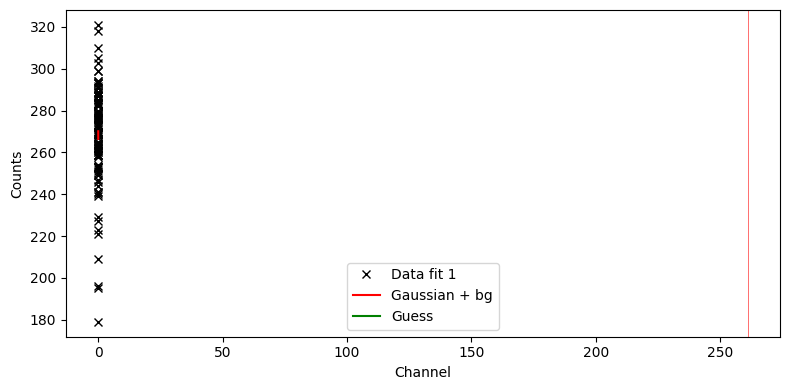

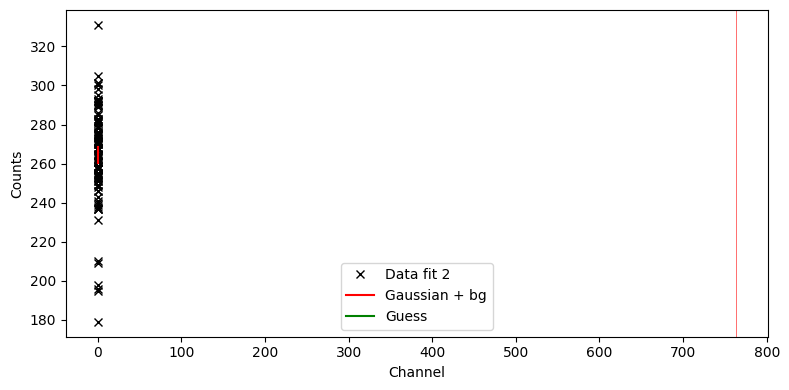

In [21]:
# Fit 1
y1_fit = gauss_bg(x1, *popt1)
y1_guess = gauss_bg(x1, *p0_1)
plt.figure(figsize=(8, 4))
plt.plot(x1, y1, 'kx', label='Data fit 1')
plt.plot(x1, y1_fit, 'r-', label='Gaussian + bg')
plt.plot(x1, y1_guess, 'g-', label='Guess')

plt.axvline(peak1_low, color='red', linewidth=0.4)
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.legend()
plt.tight_layout()
plt.savefig('vacromium_fit1.png')

plt.show()

# Fit 2
y2_fit = gauss_bg(x2, *popt2)
y2_guess = gauss_bg(x2, *p0_2)

plt.figure(figsize=(8, 4))
plt.plot(x2, y2, 'kx', label='Data fit 2')
plt.plot(x2, y2_fit, 'r-', label='Gaussian + bg')
plt.plot(x2, y2_guess, 'g-', label='Guess')


plt.axvline(peak2_low, color='red', linewidth=0.4)
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.legend()
plt.tight_layout()
plt.savefig('vacromium_fit2.png')
plt.show()


In [20]:
from uncertainties import ufloat

peak1 = ufloat(popt1[1], popt1[2])
print('Peak 1: ', peak1)

peak2 = ufloat(popt2[1], popt2[2])
print('Peak 2: ', peak2)

Peak 1:  261.7+/-3.5
Peak 2:  764+/-4
